In [11]:
import pandas as pd
pd.options.display.max_columns = 1000 # to see all columns
import json
import re
import geopandas as gpd
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import tempun
import pickle
import nltk
from nltk.util import bigrams
import matplotlib.colors as mcolors
import requests
from bs4 import BeautifulSoup

In [2]:
# read LIST dataset from zenodo
# !!! use carefully - takes time 
LIST = gpd.read_parquet("../data/large_data/LIST_v0-2.parquet")

In [3]:
LIST.shape

(528484, 69)

# List

In [8]:
EDH_overlap_all = LIST[(LIST["EDH-ID"].notnull()) & (LIST["EDCS-ID"].notnull())]
len(EDH_overlap_all)

76583

In [14]:
len(LIST[(LIST["EDH-ID"].notnull()) & (LIST["EDCS-ID"].isnull())])

3316

In [10]:
len(LIST[(LIST["EDH-ID"].isnull()) & (LIST["EDCS-ID"].notnull())])

448585

In [17]:
LIST.geometry.notnull().sum()

500030

In [16]:
((LIST["not_before"].notnull()) | (LIST["not_after"].notnull())).sum()

199249

In [18]:
(((LIST["not_before"].notnull()) | (LIST["not_after"].notnull())) & LIST.geometry.notnull()).sum()

187934

In [21]:
LIST["withinRE?"].sum()

480428

In [19]:
LIST["geotemporal?"]

187934

# Overview

In [22]:
class_overview_df = pd.DataFrame([
    dict(LIST[LIST["EDH-ID"].notnull()].groupby("type_of_inscription_auto").size().sort_values(ascending=False)),
    dict(LIST[LIST["EDH-ID"].isnull()].groupby("type_of_inscription_auto").size().sort_values(ascending=False))]).T
class_overview_df.fillna(0, inplace=True)
class_overview_df.columns = ["EDH", "EDCS"]
class_overview_df

,EDH,EDCS
epitaph,27484.0,158801.0
votive inscription,13942.0,12035.0
owner/artist inscription,5246.0,38286.0
honorific inscription,3802.0,5673.0
building/dedicatory inscription,3241.0,1526.0
mile-/leaguestone,1603.0,5228.0
identification inscription,1429.0,172090.0
military diploma,501.0,702.0
acclamation,497.0,138.0
list,320.0,7.0


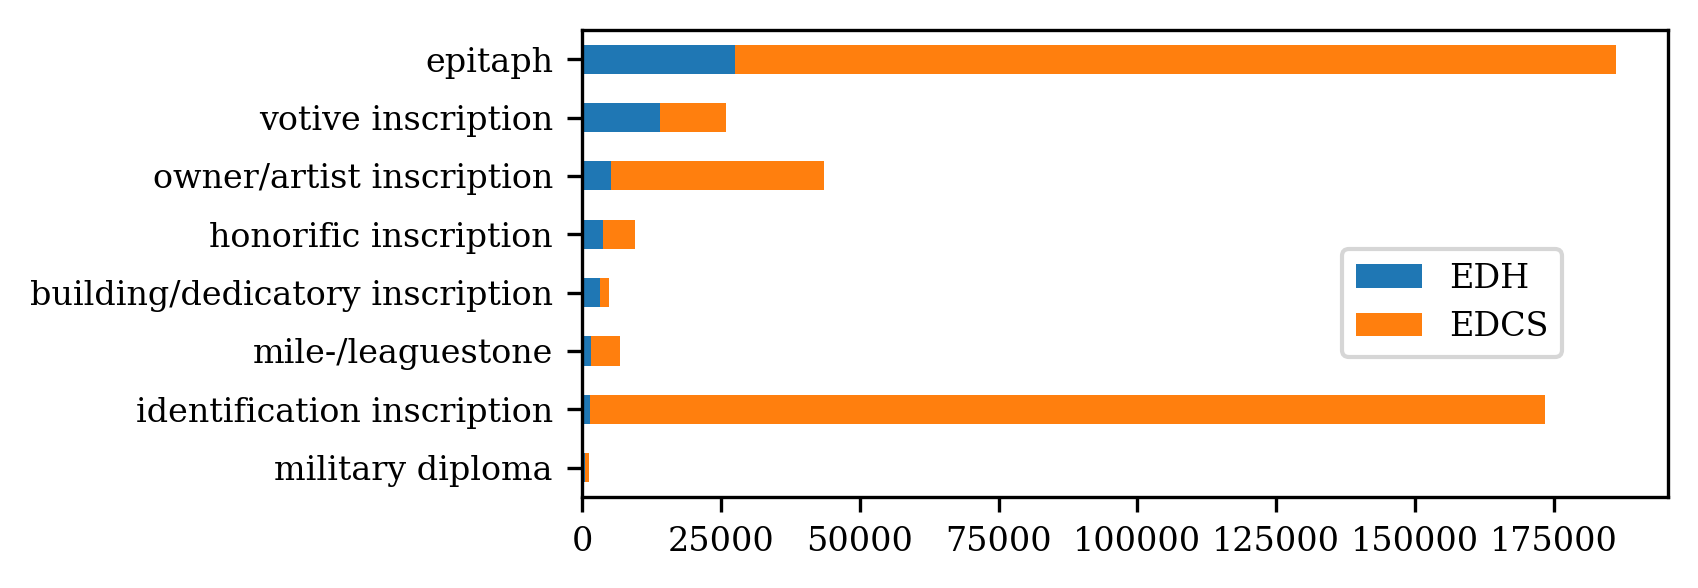

In [27]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 2), dpi=300, tight_layout=True)
class_overview_df[:8][::-1].plot.barh(stacked=True, ax=ax)
ax.legend(loc=[0.7,0.3])

In [28]:
columns = ["inscr. type", "EDH", "EDCS"]

In [29]:
class_overview_df.reset_index(inplace=True)
columns = ["inscr. type", "EDH", "EDCS"]
class_overview_df.columns = columns
class_overview_df["EDH"] = class_overview_df["EDH"].astype(int)
class_overview_df["EDCS"] = class_overview_df["EDCS"].astype(int)
class_overview_df

,inscr. type,EDH,EDCS
0,epitaph,27484,158801
1,votive inscription,13942,12035
2,owner/artist inscription,5246,38286
3,honorific inscription,3802,5673
4,building/dedicatory inscription,3241,1526
5,mile-/leaguestone,1603,5228
6,identification inscription,1429,172090
7,military diploma,501,702
8,acclamation,497,138
9,list,320,7


In [30]:
inscr_types_unique = class_overview_df["inscr. type"].tolist()
inscr_types_unique

['epitaph',
 'votive inscription',
 'owner/artist inscription',
 'honorific inscription',
 'building/dedicatory inscription',
 'mile-/leaguestone',
 'identification inscription',
 'military diploma',
 'acclamation',
 'list',
 'label',
 'defixio',
 'boundary inscription',
 'public legal inscription',
 'elogium',
 'letter',
 'seat inscription',
 'prayer',
 'private legal inscription',
 'assignation inscription',
 'calendar',
 'adnuntiatio']

In [31]:
class_overview_df[:11].append(class_overview_df[11:])

,inscr. type,EDH,EDCS
0,epitaph,27484,158801
1,votive inscription,13942,12035
2,owner/artist inscription,5246,38286
3,honorific inscription,3802,5673
4,building/dedicatory inscription,3241,1526
5,mile-/leaguestone,1603,5228
6,identification inscription,1429,172090
7,military diploma,501,702
8,acclamation,497,138
9,list,320,7


In [32]:
class_overview_df[11:].reset_index().drop("index", axis=1)

,inscr. type,EDH,EDCS
0,defixio,283,364
1,boundary inscription,233,451
2,public legal inscription,188,86
3,elogium,142,0
4,letter,124,0
5,seat inscription,81,0
6,prayer,41,0
7,private legal inscription,39,0
8,assignation inscription,14,0
9,calendar,13,0


In [33]:
class_overview_df_2col = pd.concat([class_overview_df[:11], class_overview_df[11:].reset_index().drop("index", axis=1)], axis=1, ignore_index=True)
class_overview_df_2col

,0,1,2,3,4,5
0,epitaph,27484,158801,defixio,283,364
1,votive inscription,13942,12035,boundary inscription,233,451
2,owner/artist inscription,5246,38286,public legal inscription,188,86
3,honorific inscription,3802,5673,elogium,142,0
4,building/dedicatory inscription,3241,1526,letter,124,0
5,mile-/leaguestone,1603,5228,seat inscription,81,0
6,identification inscription,1429,172090,prayer,41,0
7,military diploma,501,702,private legal inscription,39,0
8,acclamation,497,138,assignation inscription,14,0
9,list,320,7,calendar,13,0


In [34]:
class_overview_df_2col.columns = columns + columns
class_overview_df_2col

,inscr. type,EDH,EDCS,inscr. type,EDH,EDCS
0,epitaph,27484,158801,defixio,283,364
1,votive inscription,13942,12035,boundary inscription,233,451
2,owner/artist inscription,5246,38286,public legal inscription,188,86
3,honorific inscription,3802,5673,elogium,142,0
4,building/dedicatory inscription,3241,1526,letter,124,0
5,mile-/leaguestone,1603,5228,seat inscription,81,0
6,identification inscription,1429,172090,prayer,41,0
7,military diploma,501,702,private legal inscription,39,0
8,acclamation,497,138,assignation inscription,14,0
9,list,320,7,calendar,13,0


In [35]:
print(class_overview_df_2col.to_latex(index=False))

\begin{tabular}{lrrlrr}
\toprule
                    inscr. type &   EDH &   EDCS &               inscr. type &  EDH &  EDCS \\
\midrule
                        epitaph & 27484 & 158801 &                   defixio &  283 &   364 \\
             votive inscription & 13942 &  12035 &      boundary inscription &  233 &   451 \\
       owner/artist inscription &  5246 &  38286 &  public legal inscription &  188 &    86 \\
          honorific inscription &  3802 &   5673 &                   elogium &  142 &     0 \\
building/dedicatory inscription &  3241 &   1526 &                    letter &  124 &     0 \\
              mile-/leaguestone &  1603 &   5228 &          seat inscription &   81 &     0 \\
     identification inscription &  1429 & 172090 &                    prayer &   41 &     0 \\
               military diploma &   501 &    702 & private legal inscription &   39 &     0 \\
                    acclamation &   497 &    138 &   assignation inscription &   14 &     0 \\
        

In [36]:
%%time
# Generate a list of 1000 random dates for each inscription in the dataset
LIST["random_dates"] = LIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 57.2 s, sys: 5.31 s, total: 1min 2s
Wall time: 1min 5s


In [37]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        try: el = eval(el)
        except: el = [el]
        if el != None:
            return el
        else:
            return []
    elif isinstance(el, dict):
        return []
    else:
        return []
LIST["inscr_type_clean"] = LIST["inscr_type"].apply(clean_inscr_type)

In [38]:
inscr_type_list_flat = [el for ellist in LIST["inscr_type_clean"].tolist() for el in ellist]
inscr_types_edcs_freqs = list(nltk.FreqDist(inscr_type_list_flat).most_common())
inscr_types_edcs = [tup[0] for tup in inscr_types_edcs_freqs]
inscr_types_edcs[:10]

['tituli fabricationis',
 'tituli sepulcrales',
 'inscriptiones christianae, tituli sepulcrales',
 'tituli sacri',
 'tituli possessionis',
 'miliaria',
 'tituli honorarii',
 'inscriptiones christianae',
 'tituli operum',
 'tituli operum, tituli sepulcrales']

In [39]:
inscr_types_edcs_freqs

[('tituli fabricationis', 142318),
 ('tituli sepulcrales', 121731),
 ('inscriptiones christianae, tituli sepulcrales', 51670),
 ('tituli sacri', 23922),
 ('tituli possessionis', 14121),
 ('miliaria', 6229),
 ('tituli honorarii', 5518),
 ('inscriptiones christianae', 4874),
 ('tituli operum', 3607),
 ('tituli operum, tituli sepulcrales', 2996),
 ('tituli operum, tituli sacri', 2304),
 ('tituli honorarii, tituli sacri', 1801),
 ('signacula, tituli fabricationis, tituli possessionis', 1695),
 ('tituli fabricationis, tituli possessionis', 1571),
 ('carmina, tituli sepulcrales', 1242),
 ('miliaria, tituli sacri', 973),
 ('carmina', 915),
 ('inscriptiones christianae, tituli operum, tituli sepulcrales', 657),
 ('tituli sacri, tituli sepulcrales', 652),
 ('termini', 612),
 ('tituli honorarii, tituli operum', 587),
 ('carmina, inscriptiones christianae, tituli sepulcrales', 585),
 ('diplomata militaria, tituli sacri', 584),
 ('inscriptiones christianae, tituli possessionis', 577),
 ('leges', 5

In [40]:
subset_df = LIST[(LIST["EDCS-ID"].notnull()) & (LIST["inscr_type_clean"]== "tituli sepulcrales")]
len(subset_df)

0

In [42]:
base_colors_10 = list(mcolors.BASE_COLORS.keys())[:6] + ["sienna", "turquoise", "chartreuse", "blueviolet"]
base_colors_10

['b',
 'g',
 'r',
 'c',
 'm',
 'y',
 'sienna',
 'turquoise',
 'chartreuse',
 'blueviolet']

CPU times: user 2min 12s, sys: 15.2 s, total: 2min 27s
Wall time: 2min 32s


Text(0.5, 1.0, '(c)')

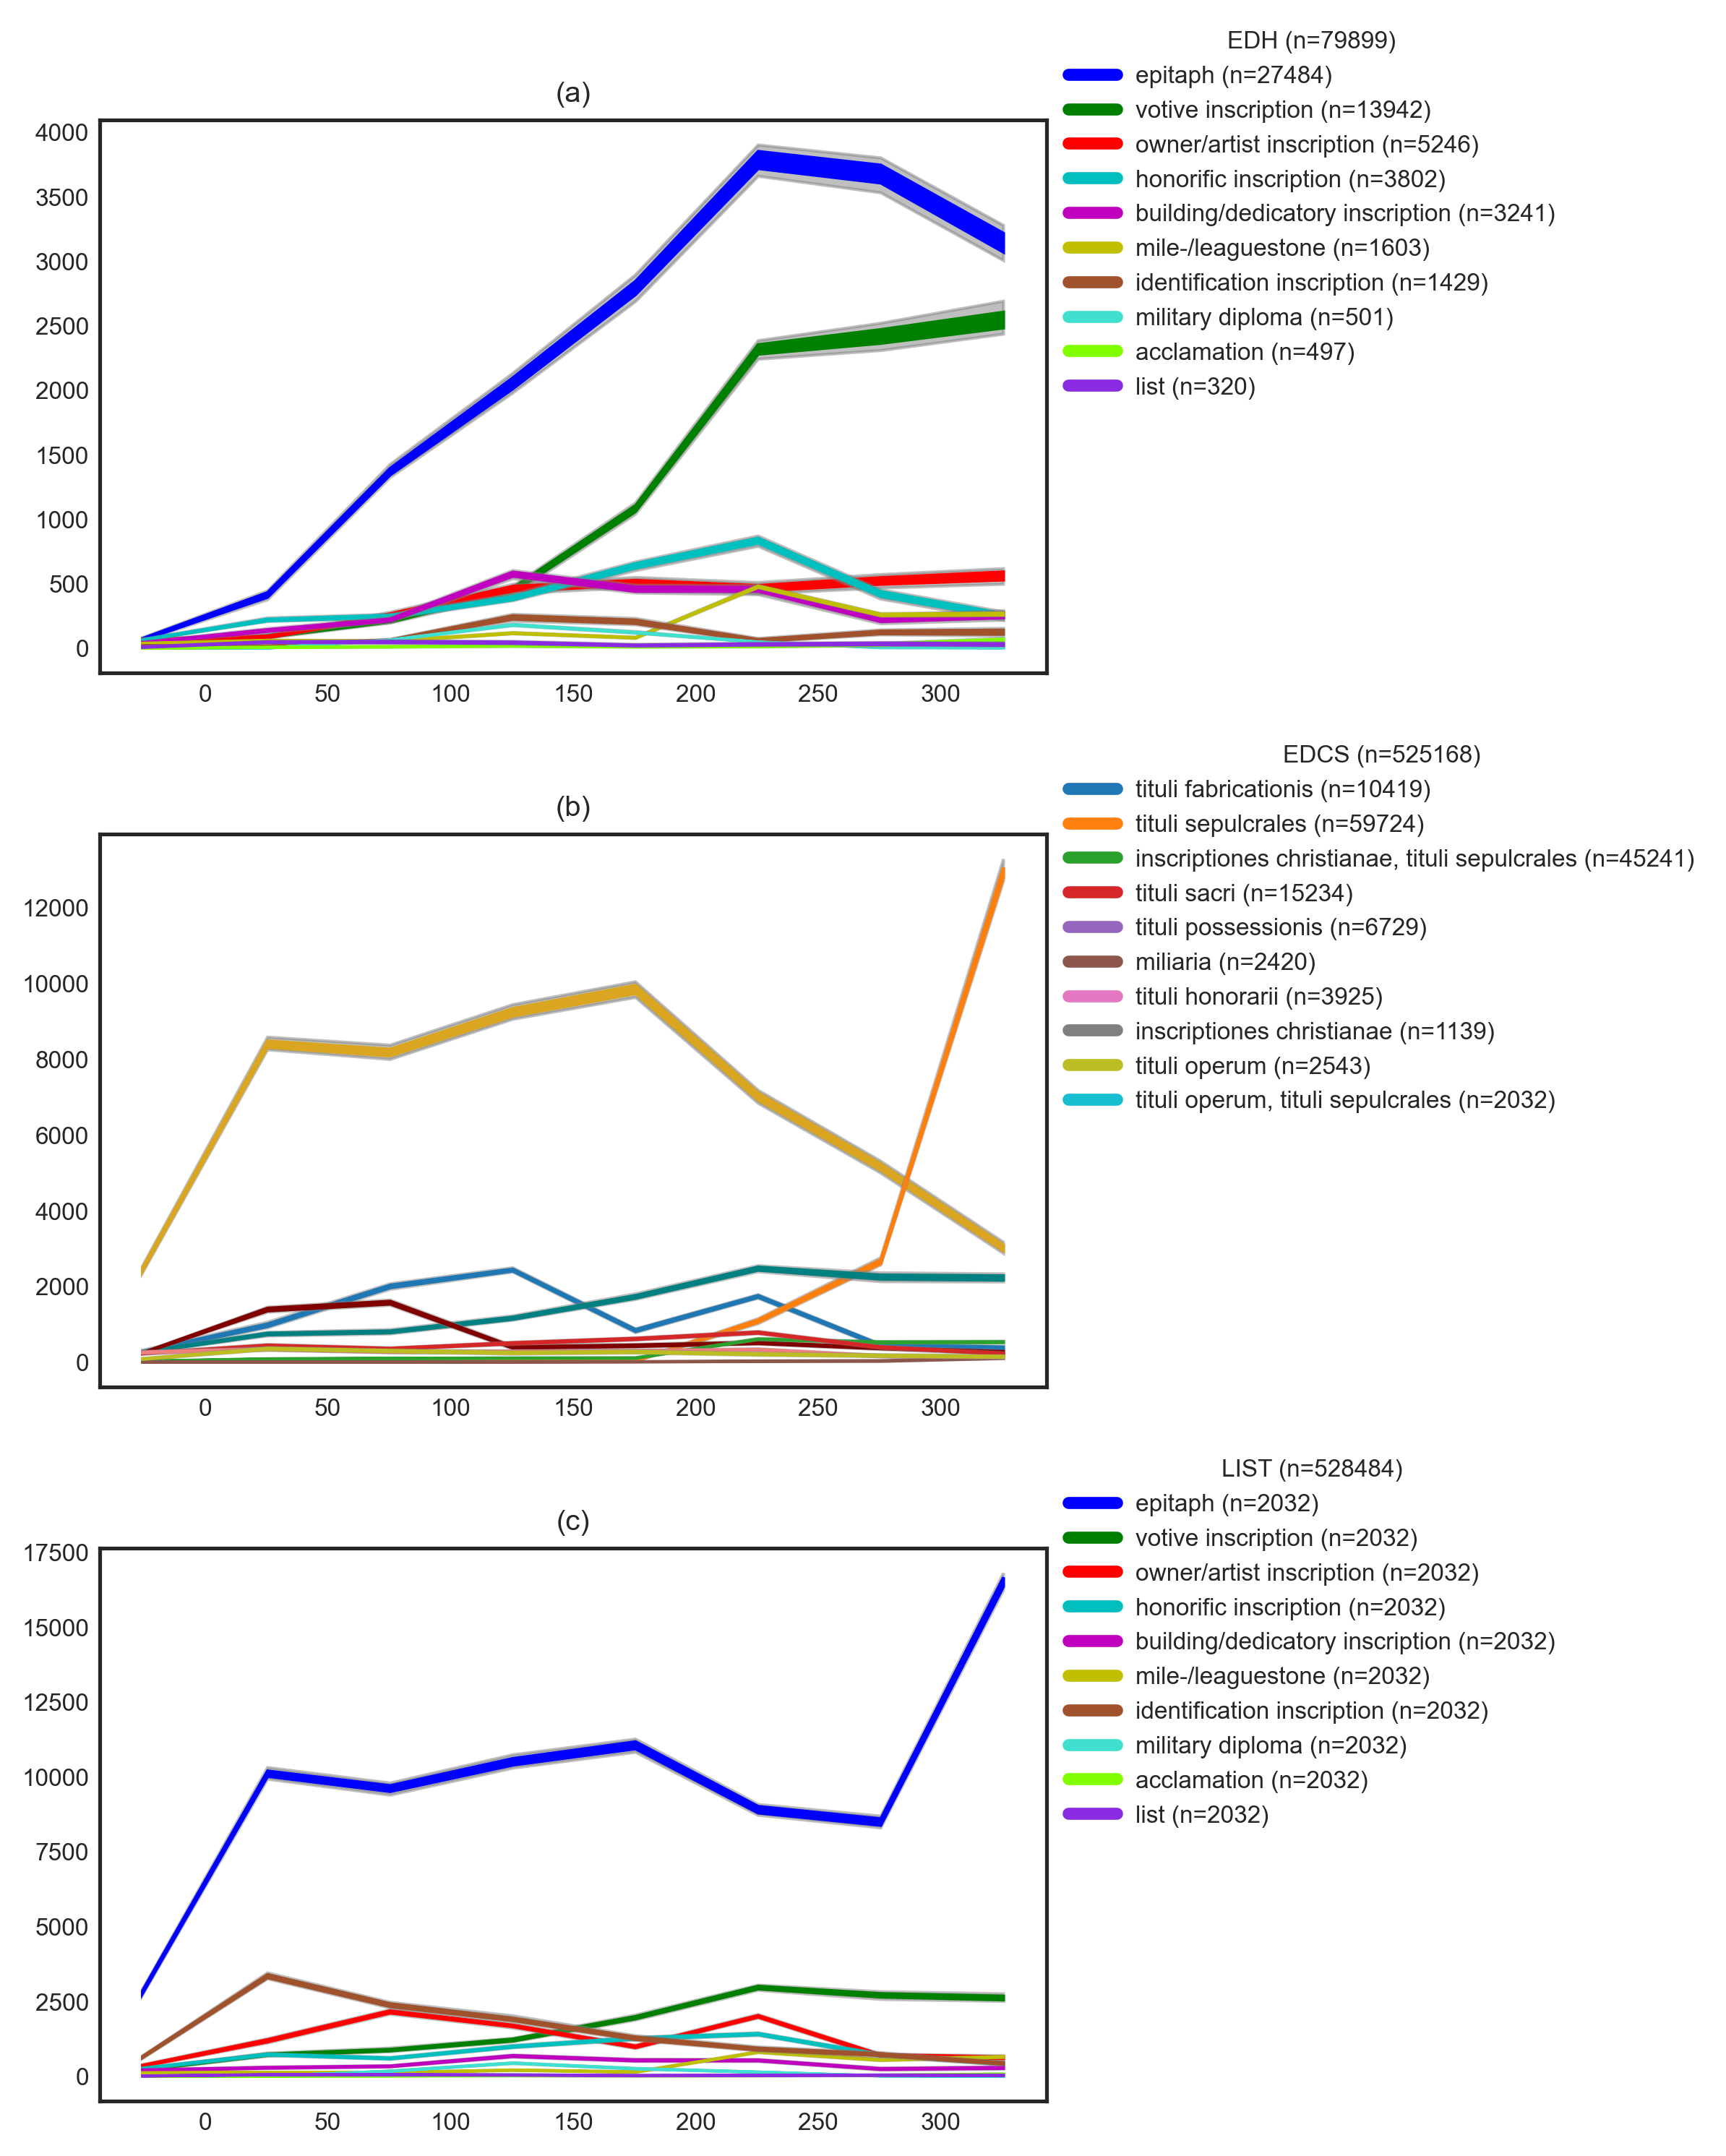

In [62]:
%%time
# Inscriptions by their type over time, EDH
# Plot combining EDH and EDCSx
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(8, 10), dpi=300, tight_layout=True)


simulations_by_type_EDH = []

for ins_type, color in zip(inscr_types_unique[:10], base_colors_10):
    subset_df = LIST[(LIST["EDH-ID"].notnull()) & (LIST["type_of_inscription_auto"]== ins_type)]
    tempun.timeblocksplot_from_randoms(subset_df["random_dates"], [-50, 350, 50], color=color, ax=ax1)
    ins_type_N = len(subset_df)
    simulations_by_type_EDH.append([ins_type, ins_type_N])
#simulations_by_type_EDH = sorted(simulations_by_type_EDH, key=lambda x: x[1], reverse=True)

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in base_colors_10]
legend_labels_EDH = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDH]

ax1.legend(markers, legend_labels_EDH, numpoints=1,
           title="EDH (n={0})".format(str(len(LIST[LIST["EDH-ID"].notnull()]))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax1.set_title("(a)")

tab_colors_list_edcs = ['tab:blue',
                        'goldenrod',
                        'tab:orange',
                        'teal',
                        'maroon',
                        'tab:green',
                        'tab:red',
                        'tab:brown',
                        'lightcoral',
                        'tab:olive']
simulations_by_type_EDCS = []
for ins_type, color in zip(inscr_types_edcs[:10], tab_colors_list_edcs):
    subset_df = LIST[((LIST["not_before"].notnull()) | (LIST["not_after"].notnull())) & (LIST["EDCS-ID"].notnull()) & (LIST["inscr_type_clean"].apply(lambda x: ins_type in x))]
    tempun.timeblocksplot_from_randoms(subset_df["random_dates"], [-50, 350, 50], color=color, ax=ax2)
    ins_type_N = len(subset_df)
    simulations_by_type_EDCS.append([ins_type, ins_type_N])
#simulations_by_type_EDCS = sorted(simulations_by_type_EDCS, key=lambda x: x[1], reverse=True)

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:10]]

legend_labels_EDCS = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDCS]

ax2.legend(markers, legend_labels_EDCS, numpoints=1,
           title="EDCS (n={0})".format(str(len(LIST[LIST["EDCS-ID"].notnull()]))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax2.set_title("(b)")


simulations_by_type_LIST = []

for ins_type, color in zip(inscr_types_unique[:10], base_colors_10):
    subset_df = LIST[((LIST["not_before"].notnull()) | (LIST["not_after"].notnull())) & (LIST["type_of_inscription_auto"]== ins_type)]
    tempun.timeblocksplot_from_randoms(subset_df["random_dates"], [-50, 350, 50], color=color, ax=ax3)
    simulations_by_type_LIST.append([ins_type, ins_type_N])
#simulations_by_type_LIST = sorted(simulations_by_type_LIST, key=lambda x: x[1], reverse=True)

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in base_colors_10[:10]]

legend_labels_LIST = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_LIST]

ax3.legend(markers, legend_labels_LIST, numpoints=1, title="LIST (n={0})".format(str(len(LIST))), fontsize=8, bbox_to_anchor=(1, 1.2), loc='upper left')

ax3.set_title("(c)")

(-400.0, 800.0)

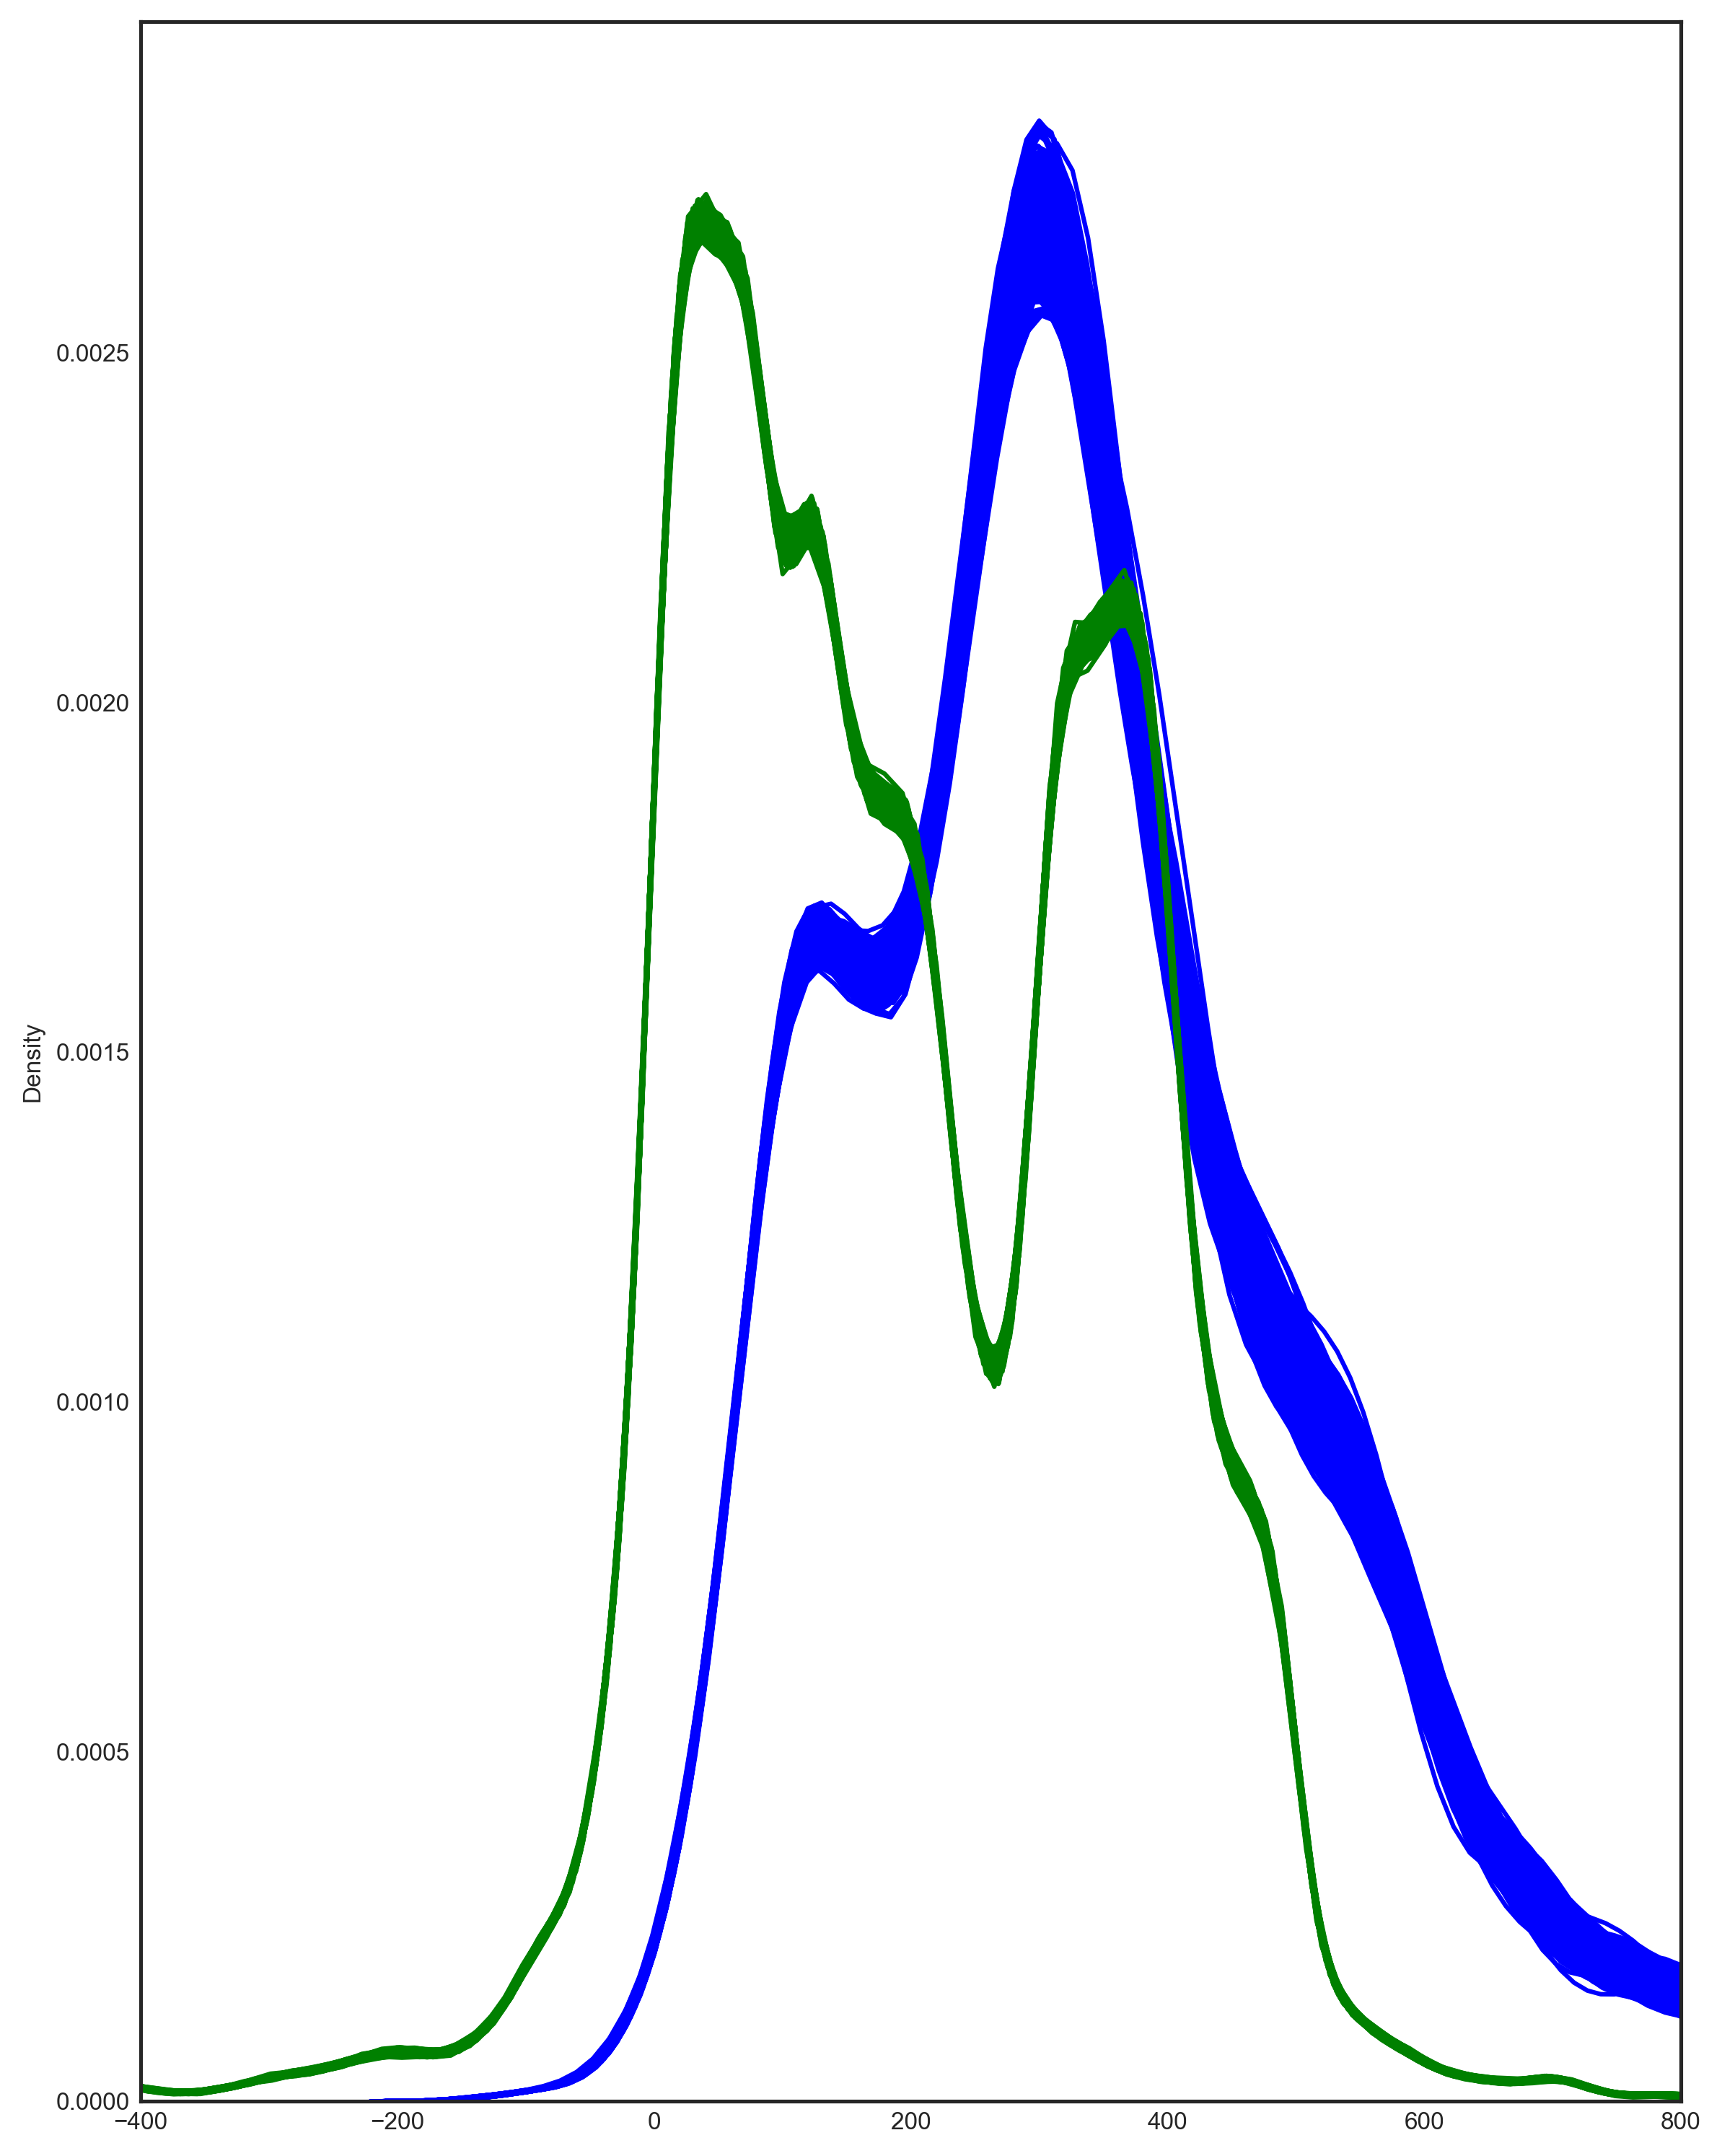

In [61]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 10), dpi=300, tight_layout=True)
tempun.kdeplot_from_randoms(LIST[LIST["EDCS-ID"].isnull()]["random_dates"], color="blue", ax=ax1)
tempun.kdeplot_from_randoms(LIST[LIST["EDH-ID"].isnull()]["random_dates"], color="green", ax=ax1)
ax1.set_xlim(-400,800)